# <span style="font-size:1.3em;">Petfinder Pawpularity Prediction Using Neural Networks
Authors: Aisha Baitemirova-Othman, Angela Kim, Steven Addison

---

# Contents
<l></l>

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>

- <a href="#Business Understanding">Business Understanding</a>  

- <a href="#Data Understanding">Data Understanding</a>  
    
- <a href="#Imports">Imports</a> 

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a>  
    
- <a href="#Modeling">Modeling</a>
    
    - <a href="#Baseline Dummy Regressor">Baseline Dummy Regressor</a>
    
    - <a href="#First Basic Model and Image Augmentation">First Basic Model and Image Augmentation</a>
    
    - <a href="#Iterative Artificial Neural Network Building">Iterative Artificial Neural Networks</a>
    
    - <a href="#Iterative Convolutional Neural Network Building">Iterative Convolutional Neural Networks</a>
    
- <a href="#Conclusion">Conclusion</a>
    
- <a href="#Next Steps">Next Steps</a>
    
- <a href="#Sources">Sources</a>

---

# <a id="#Overview">Overview</a>

> [Petfinder.my](https://www.petfinder.my/) is Malaysia’s leading animal welfare platform, featuring over 200,000 animals with more than 56,000 happily adopted. This project analyzes photos of adoptable pets from Malaysian animal shelters found on Petfinder and designs a Deep Learning model to predict the "Pawpularity" of pet photos.

# <a id="#Business Understanding">Business Understanding</a>

>They say a picture is worth a thousand words. A picture can also save a life. Hundreds of millions of stray cats and dogs suffer on the streets, live miserably in crowded shelters, or are euthanized around the world. Companion animals with attractive and high quality photos are more likely to be adopted and more likely to be adopted faster [source](https://www.tandfonline.com/doi/full/10.1080/10888705.2014.982796). We want to answer the question: what makes a good picture? After analyzing raw images and metadata to predict the “Pawpularity” of pet photos, we train and test our model on PetFinder.my's thousands of pet profiles to come up with the best recommendations on photo composition. We hope our model will help stray cats and dogs find their "furever" home faster.

# <a id="Data Understanding">Data Understanding</a>

>The data comes from thousands of pet profiles on [Petfinder.my](https://www.petfinder.my/). The `Pawpularity` score is derived from each pet profile's page view statistics at the listing pages, using an algorithm that normalizes the traffic data across different pages, platforms (web & mobile) and various metrics. Duplicate clicks, crawler bot accesses and sponsored profiles are excluded from the analysis. All the feature metadata is explained [here](https://github.com/stevenaddison/Project-4/blob/main/data/metadata.md).
---

# <a id="Imports">Imports</a>

> First, we start with importing the relevant libraries to load and clean our dataset.

In [1]:
#pip install opencv-python
#pip install scikit-image

In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras

from skimage.transform import resize
from skimage import color, io

from scipy import ndimage

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

In [3]:
# Open .csv file as pandas dataframe
df = pd.read_csv("data/train.csv")

In [4]:
# Initial look at dataframe
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
# Count of non-null values, datatypes, and total entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [6]:
# Check descriptive statistics
df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [7]:
# Check value counts
for c in df.columns:
    print ("---- %s ----" % c)
    print (df[c].value_counts())
    print("\n")

---- Id ----
a4c2d270c6827850da2a09b0436c9d7f    1
7dea94db1ec7d8e8f8c682ec2cf75e60    1
0f63638ae678ca73a513d65eae820c61    1
a4b006ae7422e3a9cf6e0a9cef257a7a    1
f320726d7bbf22b14bebe1de50587879    1
                                   ..
f710f4d952da13be1a1bcea21da87d6b    1
721d316084ff00ac1e81124d021357ee    1
12344b7b04c522857cd4c6d5511fe134    1
1851fb53e4edfeeeb79ba90e80c9c509    1
38a3b4ce806568234eb03170ce2d054d    1
Name: Id, Length: 9912, dtype: int64


---- Subject Focus ----
0    9638
1     274
Name: Subject Focus, dtype: int64


---- Eyes ----
1    7658
0    2254
Name: Eyes, dtype: int64


---- Face ----
1    8960
0     952
Name: Face, dtype: int64


---- Near ----
1    8540
0    1372
Name: Near, dtype: int64


---- Action ----
0    9813
1      99
Name: Action, dtype: int64


---- Accessory ----
0    9240
1     672
Name: Accessory, dtype: int64


---- Group ----
0    8630
1    1282
Name: Group, dtype: int64


---- Collage ----
0    9420
1     492
Name: Collage, dtype: in

>There are 9912 images and 12 features: `Subject Focus`, `Eyes`, `Face`, `Near`, `Action`, `Accessory`, `Group`, `Collage`, `Human`, `Occlusion`, `Info`, and `Blur` . The target variable is `Pawpularity` and ranges from 1-100. There are no null values and all features have a value of 0 (no) or 1 (yes).

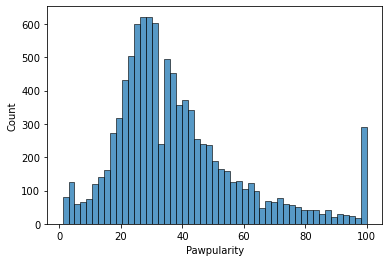

In [9]:
sns.histplot(df['Pawpularity']);

> Here we take at a look at the distribution of the target `Pawpularity` and see a spike at 100.

In [10]:
# Download images to notebook
images = []
count = 0
for index in range(len(df)):
    Id = df.loc[index, 'Id']
    path = 'data/train/'+str(Id)+'.jpg'
    img_array = cv2.imread(path)
    img_array = resize(img_array, (128, 128), anti_aliasing=True)
    images.append(img_array)
    count += 1
    progress = (count/len(df))*100
    print('progress =', round(progress,2), '%', end='\r')

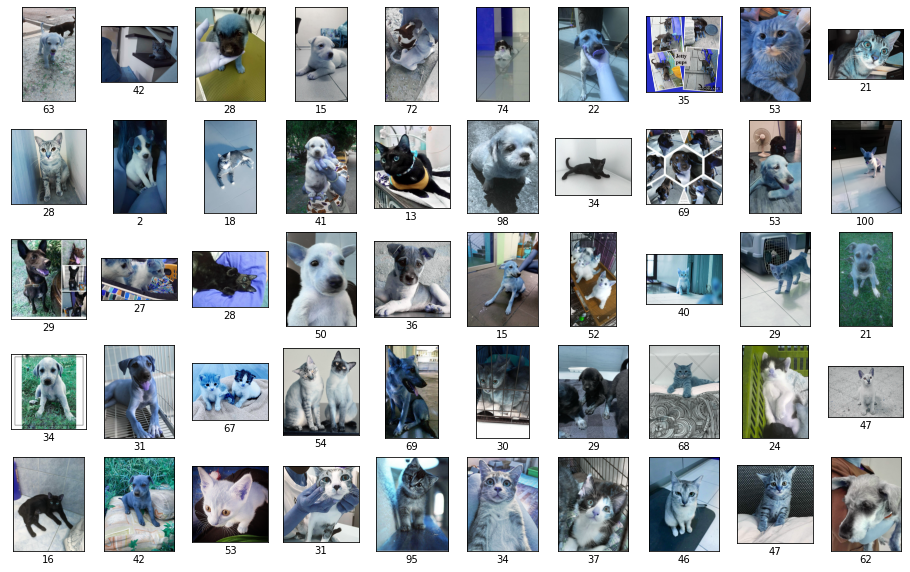

In [11]:
# Plot first 50 images
def image_read(path):
    return cv2.imread(path)

df['path'] = df.apply(lambda x : 'data/train/' + x['Id'] + ".jpg", axis=1)
fig, ax = plt.subplots(5,10,figsize=(16, 10))
for i, (path, score) in enumerate(df[['path', 'Pawpularity']][:50].values.tolist()):
    row, col = i // 10, i % 10
    axis = ax[row][col]
    axis.imshow(image_read(path))
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(score)
plt.show()

> We see a variety of cat and dog photos and their `Pawpularity` score. Something we notice is that the photos lean blue but do not know why and cannot find more information on this.

In [13]:
# Transforming images list to numpy array for modeling and assigning it to X and defining target variable y
X = np.array(images)
y = df['Pawpularity']

# Checking shape of X
X.shape

(9912, 64, 64, 3)

In [15]:
# Do a train-test-split using a random state of 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

---

# <a id="Modeling">Modeling</a>

> We start by creating functions for model building and evaluation to streamline our process.

In [16]:
# Function for model building
def model_compfit(model, X_train, y_train, n_epochs):
    """Function to compile our models using our chosen optimizer, loss,
    and evaluation metrics. The function then fits the model on our train
    data and n number epochs, finally printing out a model summary."""
    
    # compile model with adam optimizer and mean squared error metric
    model.compile(optimizer='adam',
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])
    # fit model on train sets with n number epochs
    model.fit(X_train, y_train, epochs=n_epochs)
    
    #print model summary
    model.summary()

In [17]:
# Function for model evaluation
def model_eval(model, X_train, y_train, X_test, y_test, name):
    """Function to evaluate our model on the training and test 
    data, then printing out those metrics, and visualizing the
    predictions on the test data."""
    
    # calculate training data metrics
    train_eval = model.evaluate(X_train, y_train)
    
    # calculate test data metrics
    test_eval = model.evaluate(X_test, y_test)
    
    # print metrics
    print(f"""
    {name} Training Metrics:
    Loss: {round(train_eval[0] , 3)}
    RMSE: {round(train_eval[1] , 3)} 
    ------
    {name} Test Metrics:
    Loss: {round(test_eval[0] , 3)}
    RMSE: {round(test_eval[1] , 3)}
    """)
    
    # visualize predictions
    ypred = model.predict(X_test)
    x_ax = range(len(ypred))
    plt.figure(figsize=(20,10))
    plt.scatter(x_ax, y_test, s=15, color="blue", label="original")
    plt.plot(x_ax, ypred, lw=1, color="red", label="predicted")
    plt.legend()
    plt.show()

### <a id="Baseline Dummy Regressor">Baseline Dummy Regressor<a>

> We start off with a Baseline Dummy Regressor to compare our models to and try to improve upon.

In [18]:
baseline = DummyRegressor(strategy="mean")
baseline.fit (X_train,y_train)
y_hat_test = baseline.predict(X_test)
baseline_rmse = mse(y_test, y_hat_test, squared=False)

In [19]:
baseline_rmse

21.074920522735773

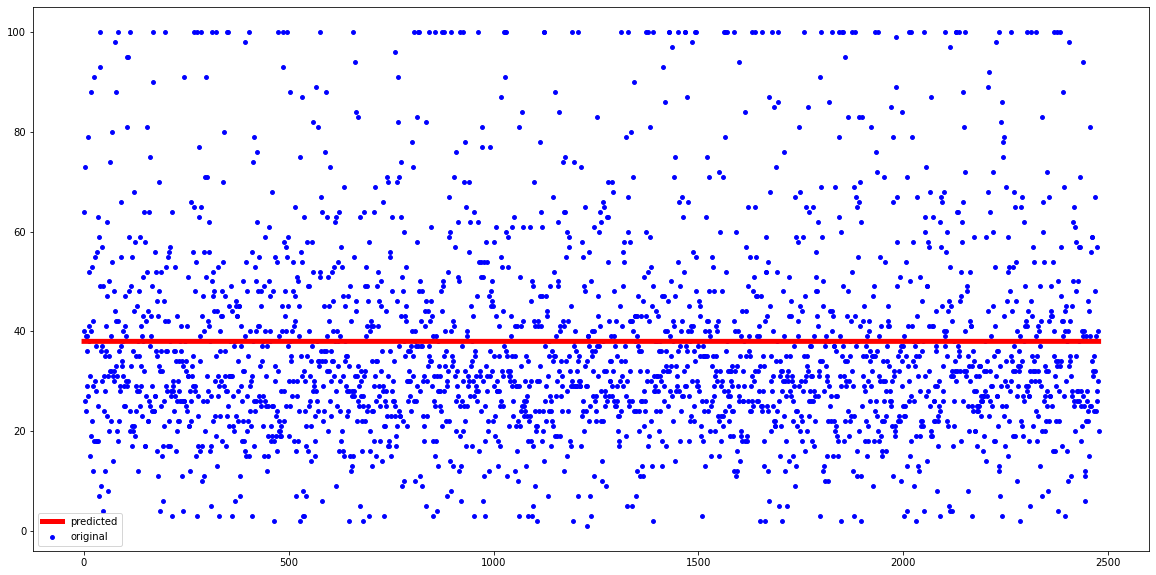

In [20]:
ypred = baseline.predict(X_test)
x_ax = range(len(ypred))
plt.figure(figsize=(20,10))
plt.scatter(x_ax, y_test, s=15, color="blue", label="original")
plt.plot(x_ax, ypred, lw=5, color="red", label="predicted")
plt.legend()
plt.show()

### <a id="First Basic Model and Image Augmentation">First Basic Model and Image Augmentation</a>

> Our first basic model is an Artificial Neural Network with one layer.

In [21]:
basicann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(basicann, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 3ms/step - loss: 498.3906 - root_mean_squared_error: 22.3247
Epoch 2/10
233/233 [==============================] - 1s 2ms/step - loss: 479.4647 - root_mean_squared_error: 21.8967
Epoch 3/10
233/233 [==============================] - 1s 2ms/step - loss: 472.3744 - root_mean_squared_error: 21.7342
Epoch 4/10
233/233 [==============================] - 1s 2ms/step - loss: 472.8121 - root_mean_squared_error: 21.7442
Epoch 5/10
233/233 [==============================] - 1s 3ms/step - loss: 470.8164 - root_mean_squared_error: 21.6983
Epoch 6/10
233/233 [==============================] - 1s 2ms/step - loss: 468.0627 - root_mean_squared_error: 21.6348
Epoch 7/10
233/233 [==============================] - 1s 2ms/step - loss: 466.6101 - root_mean_squared_error: 21.6012
Epoch 8/10
233/233 [==============================] - 1s 2ms/step - loss: 469.0668 - root_mean_squared_error: 21.6579
Epoch 9/10
233/233 [==============================] - 1s

78/78 [==============================] - 0s 2ms/step - loss: 499.9927 - root_mean_squared_error: 22.3605

    Basic ANN Training Metrics:
    Loss: 453.054
    Root Mean Square Error: 21.285
    Cross Validation Score: 
    ------
    Basic ANN Test Metrics:
    Loss: 499.993
    Root Mean Square Error: 22.361
    


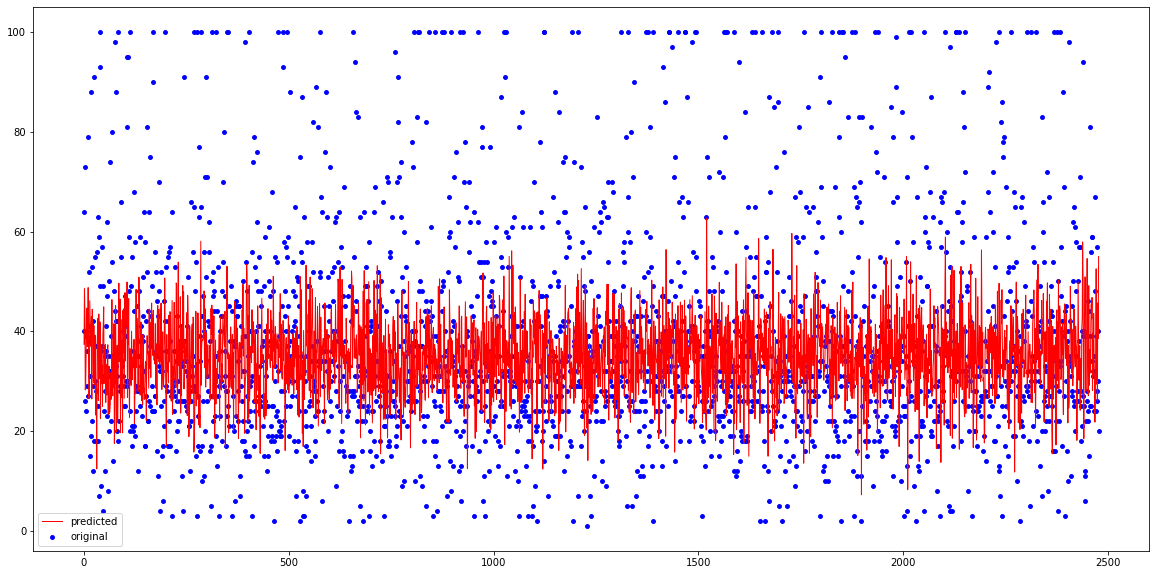

In [22]:
model_eval(basicann, X_train, y_train, X_test, y_test, 'Basic ANN')

> We do some image augmentation by blurring the photos to see how that affects our RMSE.

In [23]:
X_train_blur = []

for image in X_train:
    image = ndimage.gaussian_filter(image, sigma= 1)
    X_train_blur.append(image)
    
X_train_blur = np.array(X_train_blur)

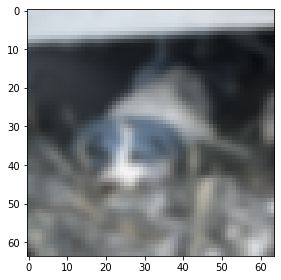

In [24]:
io.imshow(X_train_blur[0])

In [25]:
blurann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(blurann, X_train_blur, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 3ms/step - loss: 500.3907 - root_mean_squared_error: 22.3694
Epoch 2/10
233/233 [==============================] - 1s 2ms/step - loss: 479.8951 - root_mean_squared_error: 21.9065
Epoch 3/10
233/233 [==============================] - 1s 2ms/step - loss: 476.5358 - root_mean_squared_error: 21.8297
Epoch 4/10
233/233 [==============================] - 1s 2ms/step - loss: 473.2297 - root_mean_squared_error: 21.7538
Epoch 5/10
233/233 [==============================] - 1s 2ms/step - loss: 474.7428 - root_mean_squared_error: 21.7886
Epoch 6/10
233/233 [==============================] - 1s 2ms/step - loss: 476.3826 - root_mean_squared_error: 21.8262
Epoch 7/10
233/233 [==============================] - 1s 2ms/step - loss: 472.1709 - root_mean_squared_error: 21.7295
Epoch 8/10
233/233 [==============================] - 1s 2ms/step - loss: 470.9337 - root_mean_squared_error: 21.7010
Epoch 9/10
233/233 [==============================] - 1s

78/78 [==============================] - 0s 2ms/step - loss: 512.8998 - root_mean_squared_error: 22.6473

    Blurred ANN Training Metrics:
    Loss: 469.552
    Root Mean Square Error: 21.669
    Cross Validation Score: 
    ------
    Blurred ANN Test Metrics:
    Loss: 512.9
    Root Mean Square Error: 22.647
    


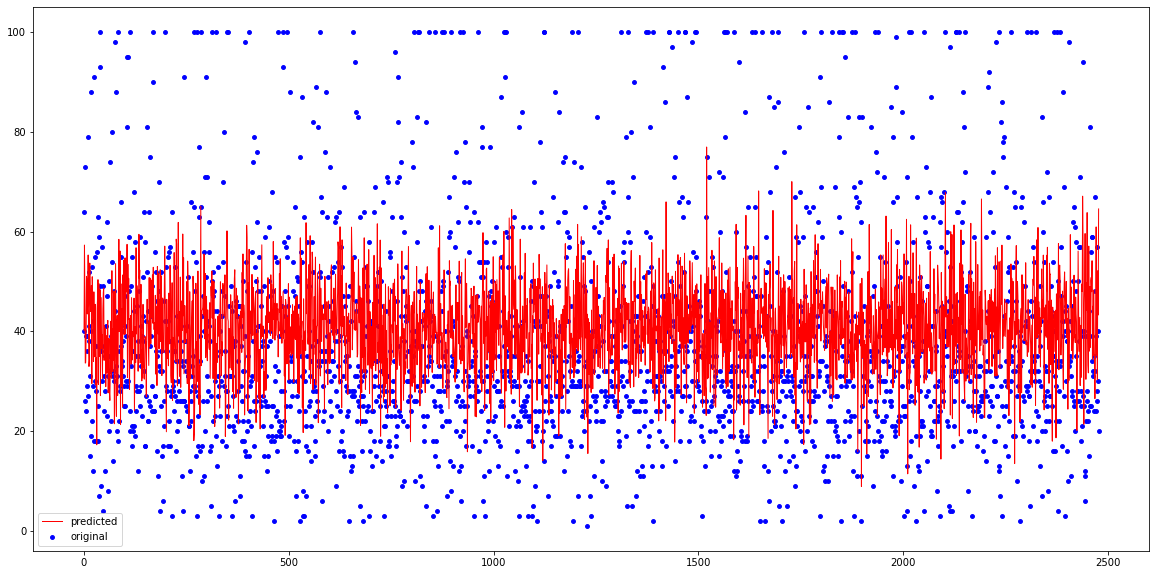

In [26]:
model_eval(blurann, X_train_blur, y_train, X_test, y_test, 'Blurred ANN')

> We then flip the images horizontally.

In [27]:
X_train_flip = []

for image in X_train:
    image = cv2.flip(image,1)
    X_train_flip.append(image)
    
X_train_flip = np.array(X_train_flip)

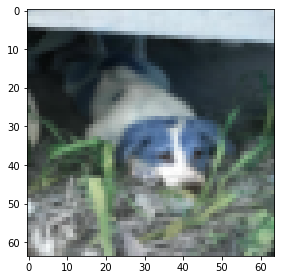

In [28]:
io.imshow(X_train_flip[0])

In [29]:
flipann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(flipann, X_train_flip, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 3ms/step - loss: 494.9866 - root_mean_squared_error: 22.2483
Epoch 2/10
233/233 [==============================] - 1s 3ms/step - loss: 472.9085 - root_mean_squared_error: 21.7465
Epoch 3/10
233/233 [==============================] - 1s 3ms/step - loss: 473.1294 - root_mean_squared_error: 21.7515
Epoch 4/10
233/233 [==============================] - 1s 3ms/step - loss: 470.5083 - root_mean_squared_error: 21.6912
Epoch 5/10
233/233 [==============================] - 1s 2ms/step - loss: 469.7913 - root_mean_squared_error: 21.6747
Epoch 6/10
233/233 [==============================] - 1s 2ms/step - loss: 466.7850 - root_mean_squared_error: 21.6052
Epoch 7/10
233/233 [==============================] - 1s 2ms/step - loss: 465.3057 - root_mean_squared_error: 21.5709
Epoch 8/10
233/233 [==============================] - 1s 2ms/step - loss: 463.1267 - root_mean_squared_error: 21.5204
Epoch 9/10
233/233 [==============================] - 1s

78/78 [==============================] - 0s 3ms/step - loss: 494.2200 - root_mean_squared_error: 22.2311

    Flipped ANN Training Metrics:
    Loss: 452.614
    Root Mean Square Error: 21.275
    Cross Validation Score: 
    ------
    Flipped ANN Test Metrics:
    Loss: 494.22
    Root Mean Square Error: 22.231
    


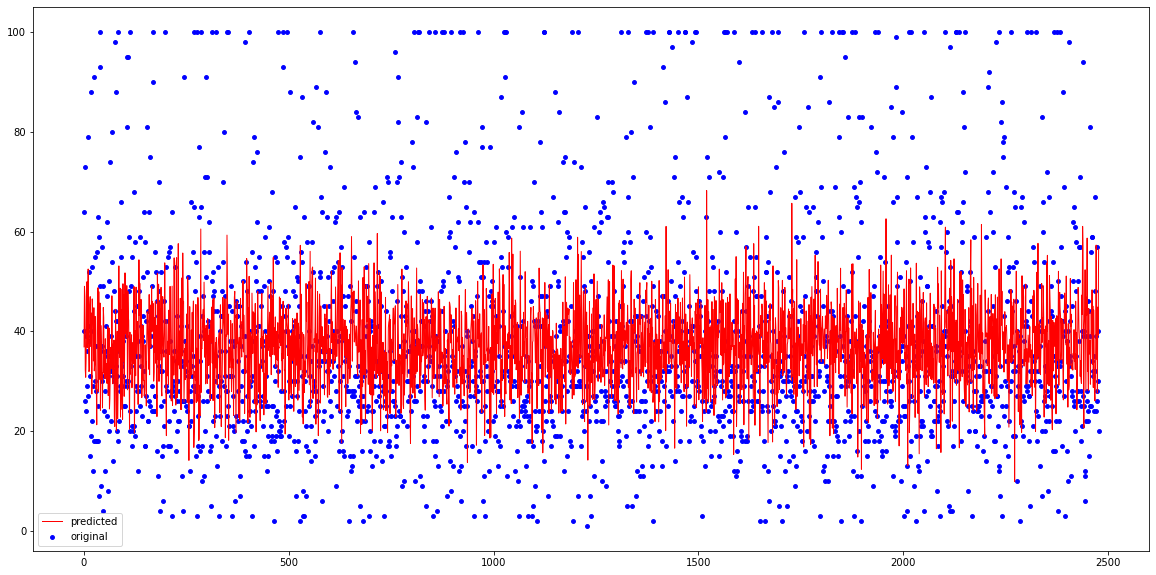

In [30]:
model_eval(flipann, X_train_flip, y_train, X_test, y_test, 'Flipped ANN')

> Both types of image augmentation performed worse than our baseline.

### <a id="Iterative Artificial Neural Network Building">Iterative Artificial Neural Networks</a>

> We move on to build more complex ANN models.

In [31]:
ann2 = Sequential([
        Flatten(),
        Dense(1000, activation='relu'),
        Dense(1, activation='relu')
      ])

model_compfit(ann2, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 18s 79ms/step - loss: 516.5323 - root_mean_squared_error: 22.7273
Epoch 2/10
233/233 [==============================] - 18s 77ms/step - loss: 480.5948 - root_mean_squared_error: 21.9225
Epoch 3/10
233/233 [==============================] - 18s 77ms/step - loss: 473.2849 - root_mean_squared_error: 21.7551
Epoch 4/10
233/233 [==============================] - 18s 78ms/step - loss: 464.1303 - root_mean_squared_error: 21.5437
Epoch 5/10
233/233 [==============================] - 20s 84ms/step - loss: 459.9240 - root_mean_squared_error: 21.4458
Epoch 6/10
233/233 [==============================] - 19s 79ms/step - loss: 454.0776 - root_mean_squared_error: 21.3091
Epoch 7/10
233/233 [==============================] - 18s 75ms/step - loss: 450.4849 - root_mean_squared_error: 21.2246
Epoch 8/10
233/233 [==============================] - 18s 77ms/step - loss: 446.7320 - root_mean_squared_error: 21.1360
Epoch 9/10
233/233 [====================

78/78 [==============================] - 2s 20ms/step - loss: 484.3192 - root_mean_squared_error: 22.0073

    Second ANN Training Metrics:
    Loss: 430.976
    Root Mean Square Error: 20.76
    Cross Validation Score: 
    ------
    Second ANN Test Metrics:
    Loss: 484.319
    Root Mean Square Error: 22.007
    


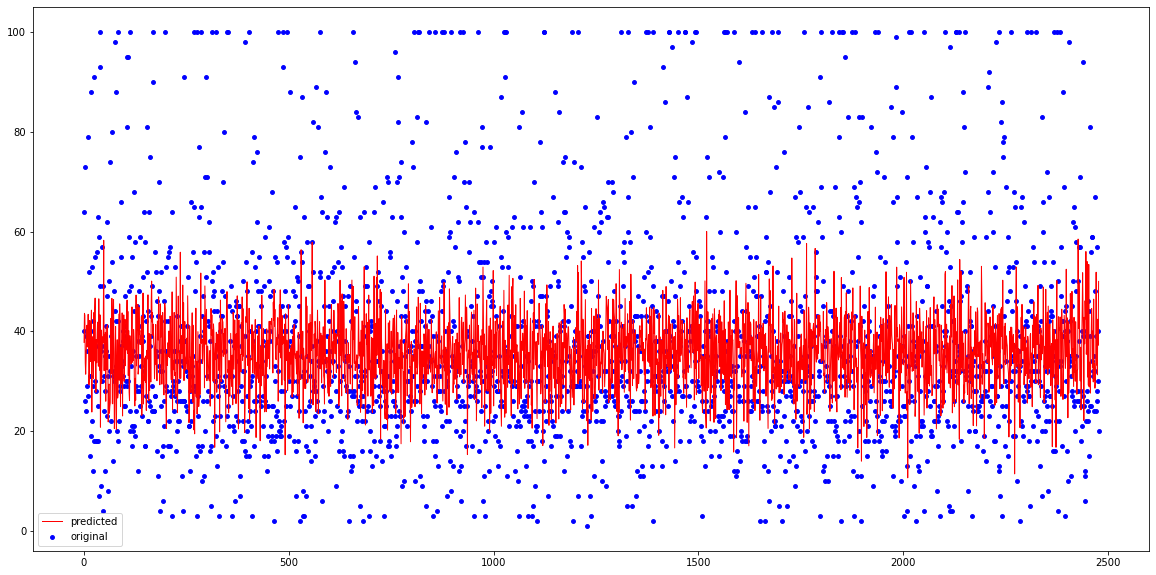

In [32]:
model_eval(ann2, X_train, y_train, X_test, y_test, 'Second ANN')

In [33]:
ann3 = Sequential([
        Flatten(),
        Dense(3000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(10, activation='relu')
      ])

model_compfit(ann3, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 58s 247ms/step - loss: 518.2277 - root_mean_squared_error: 22.7646
Epoch 2/10
233/233 [==============================] - 57s 243ms/step - loss: 478.1443 - root_mean_squared_error: 21.8665
Epoch 3/10
233/233 [==============================] - 57s 244ms/step - loss: 469.2918 - root_mean_squared_error: 21.6631
Epoch 4/10
233/233 [==============================] - 56s 242ms/step - loss: 468.0378 - root_mean_squared_error: 21.6342
Epoch 5/10
233/233 [==============================] - 57s 244ms/step - loss: 463.3850 - root_mean_squared_error: 21.5264
Epoch 6/10
233/233 [==============================] - 56s 242ms/step - loss: 456.5744 - root_mean_squared_error: 21.3676
Epoch 7/10
233/233 [==============================] - 56s 242ms/step - loss: 448.2913 - root_mean_squared_error: 21.1729
Epoch 8/10
233/233 [==============================] - 56s 241ms/step - loss: 442.4211 - root_mean_squared_error: 21.0338
Epoch 9/10
233/233 [============

78/78 [==============================] - 5s 70ms/step - loss: 489.0393 - root_mean_squared_error: 22.1142

    Third ANN Training Metrics:
    Loss: 437.359
    Root Mean Square Error: 20.913
    Cross Validation Score: 
    ------
    Third ANN Test Metrics:
    Loss: 489.039
    Root Mean Square Error: 22.114
    


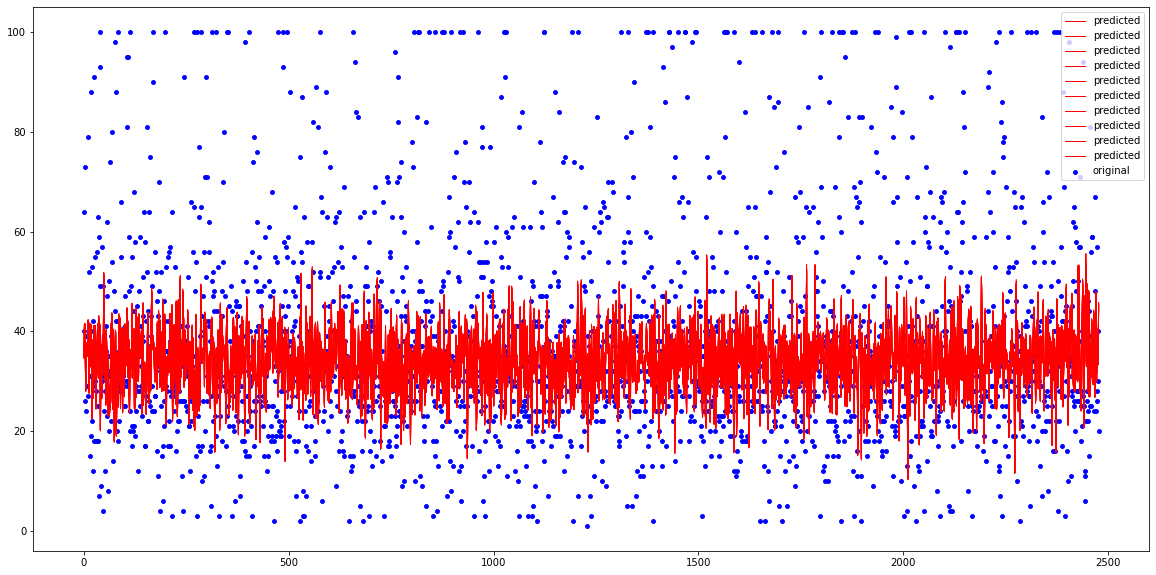

In [34]:
model_eval(ann3, X_train, y_train, X_test, y_test, 'Third ANN')

In [35]:
ann4 = Sequential([
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=1, activation='relu')
])

model_compfit(ann4, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 3s 14ms/step - loss: 516.2845 - root_mean_squared_error: 22.7219
Epoch 2/10
233/233 [==============================] - 3s 14ms/step - loss: 487.2016 - root_mean_squared_error: 22.0726
Epoch 3/10
233/233 [==============================] - 3s 13ms/step - loss: 474.2599 - root_mean_squared_error: 21.7775
Epoch 4/10
233/233 [==============================] - 3s 14ms/step - loss: 471.6286 - root_mean_squared_error: 21.7170
Epoch 5/10
233/233 [==============================] - 3s 13ms/step - loss: 463.2362 - root_mean_squared_error: 21.5229
Epoch 6/10
233/233 [==============================] - 3s 13ms/step - loss: 459.1429 - root_mean_squared_error: 21.4276
Epoch 7/10
233/233 [==============================] - 3s 13ms/step - loss: 460.7658 - root_mean_squared_error: 21.4655
Epoch 8/10
233/233 [==============================] - 3s 13ms/step - loss: 448.2278 - root_mean_squared_error: 21.1714
Epoch 9/10
233/233 [============================

78/78 [==============================] - 0s 6ms/step - loss: 487.6774 - root_mean_squared_error: 22.0834

    Fourth ANN Training Metrics:
    Loss: 434.173
    Root Mean Square Error: 20.837
    Cross Validation Score: 
    ------
    Fourth ANN Test Metrics:
    Loss: 487.677
    Root Mean Square Error: 22.083
    


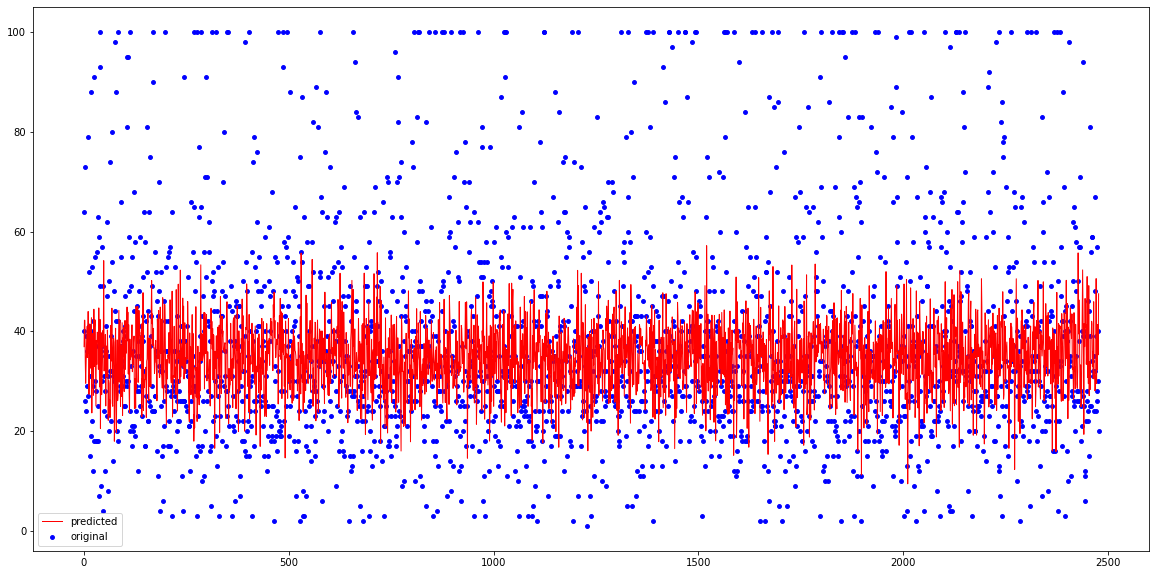

In [36]:
model_eval(ann4, X_train, y_train, X_test, y_test, 'Fourth ANN')

In [37]:
ann5 = tf.keras.Sequential([
        Flatten(input_shape=(64, 64, 3)),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=1, activation='relu')
])

model_compfit(ann5, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 3s 14ms/step - loss: 497.2830 - root_mean_squared_error: 22.2998
Epoch 2/10
233/233 [==============================] - 3s 14ms/step - loss: 469.4828 - root_mean_squared_error: 21.6676
Epoch 3/10
233/233 [==============================] - 3s 14ms/step - loss: 464.7306 - root_mean_squared_error: 21.5576
Epoch 4/10
233/233 [==============================] - 3s 13ms/step - loss: 466.2845 - root_mean_squared_error: 21.5936
Epoch 5/10
233/233 [==============================] - 3s 13ms/step - loss: 451.8568 - root_mean_squared_error: 21.2569
Epoch 6/10
233/233 [==============================] - 3s 13ms/step - loss: 447.8299 - root_mean_squared_error: 21.1620
Epoch 7/10
233/233 [==============================] - 3s 13ms/step - loss: 445.2839 - root_mean_squared_error: 21.1018
Epoch 8/10
233/233 [==============================] - 3s 13ms/step - loss: 443.0911 - root_mean_squared_error: 21.0497
Epoch 9/10
233/233 [============================

78/78 [==============================] - 0s 6ms/step - loss: 480.0600 - root_mean_squared_error: 21.9103

    Fifth ANN Training Metrics:
    Loss: 429.822
    Root Mean Square Error: 20.732
    Cross Validation Score: 
    ------
    Fifth ANN Test Metrics:
    Loss: 480.06
    Root Mean Square Error: 21.91
    


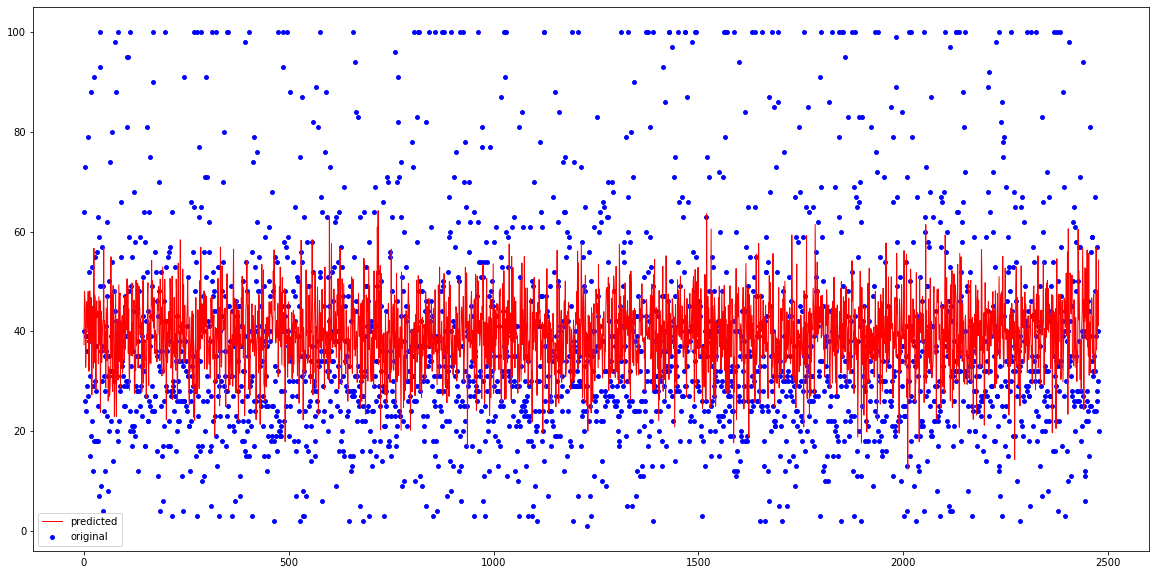

In [38]:
model_eval(ann5, X_train, y_train, X_test, y_test, 'Fifth ANN')

> We made five total ANN models, and they all performed worse than the baseline.

### <a id="Iterative Convolutional Neural Network Building">Iterative Convolutional Neural Networks</a>

> We move on to making Convolutional Neural Network models, hoping to do better than our baseline.

In [39]:
CNN = Sequential([
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (4, 4), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='relu'),
])

model_compfit(CNN, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 27s 116ms/step - loss: 498.9661 - root_mean_squared_error: 22.3375
Epoch 2/10
233/233 [==============================] - 26s 113ms/step - loss: 435.1250 - root_mean_squared_error: 20.8596
Epoch 3/10
233/233 [==============================] - 27s 115ms/step - loss: 435.3168 - root_mean_squared_error: 20.8642
Epoch 4/10
233/233 [==============================] - 26s 113ms/step - loss: 427.3121 - root_mean_squared_error: 20.6715
Epoch 5/10
233/233 [==============================] - 26s 113ms/step - loss: 432.3986 - root_mean_squared_error: 20.7942
Epoch 6/10
233/233 [==============================] - 26s 114ms/step - loss: 423.9828 - root_mean_squared_error: 20.5908
Epoch 7/10
233/233 [==============================] - 26s 113ms/step - loss: 426.6369 - root_mean_squared_error: 20.6552
Epoch 8/10
233/233 [==============================] - 26s 114ms/step - loss: 427.2395 - root_mean_squared_error: 20.6698
Epoch 9/10
233/233 [============

78/78 [==============================] - 2s 21ms/step - loss: 446.1990 - root_mean_squared_error: 21.1234

    First CNN Training Metrics:
    Loss: 417.101
    Root Mean Square Error: 20.423
    Cross Validation Score: 
    ------
    First CNN Test Metrics:
    Loss: 446.199
    Root Mean Square Error: 21.123
    


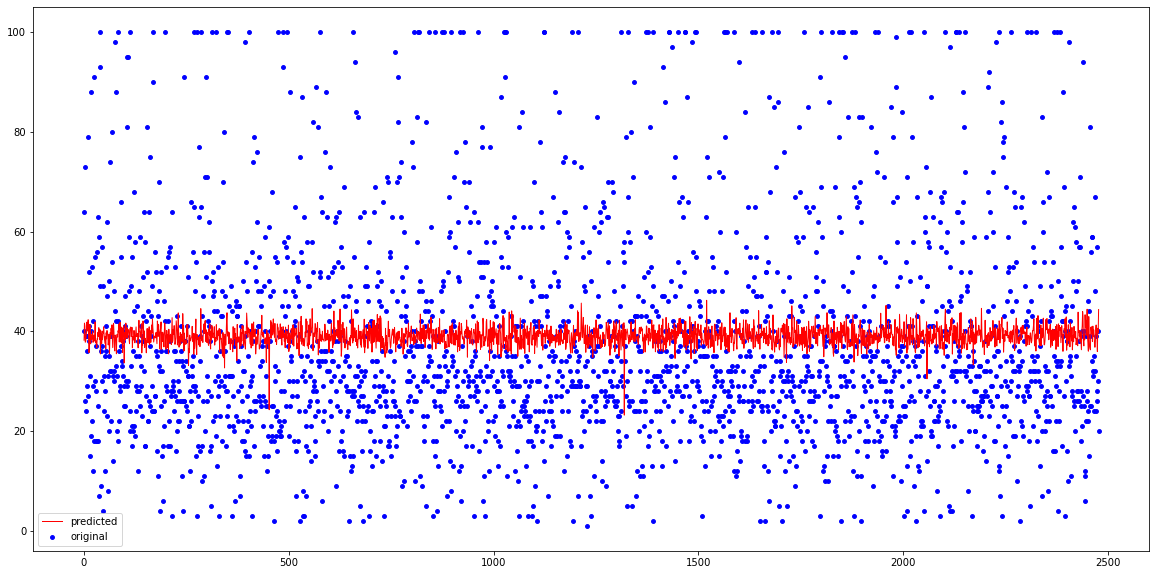

In [40]:
model_eval(CNN, X_train, y_train, X_test, y_test, 'First CNN')

In [41]:
CNN2 = Sequential([
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='relu'),
])

model_compfit(CNN2, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 18s 78ms/step - loss: 472.3835 - root_mean_squared_error: 21.7344
Epoch 2/10
233/233 [==============================] - 18s 78ms/step - loss: 431.2496 - root_mean_squared_error: 20.7666
Epoch 3/10
233/233 [==============================] - 18s 77ms/step - loss: 432.0077 - root_mean_squared_error: 20.7848
Epoch 4/10
233/233 [==============================] - 18s 77ms/step - loss: 424.8310 - root_mean_squared_error: 20.6114
Epoch 5/10
233/233 [==============================] - 18s 77ms/step - loss: 421.6907 - root_mean_squared_error: 20.5351
Epoch 6/10
233/233 [==============================] - 18s 77ms/step - loss: 409.6101 - root_mean_squared_error: 20.2388
Epoch 7/10
233/233 [==============================] - 18s 78ms/step - loss: 406.7177 - root_mean_squared_error: 20.1672
Epoch 8/10
233/233 [==============================] - 18s 77ms/step - loss: 393.3855 - root_mean_squared_error: 19.8339
Epoch 9/10
233/233 [====================

78/78 [==============================] - 2s 21ms/step - loss: 493.1283 - root_mean_squared_error: 22.2065

    Second CNN Training Metrics:
    Loss: 355.622
    Root Mean Square Error: 18.858
    Cross Validation Score: 
    ------
    Second CNN Test Metrics:
    Loss: 493.128
    Root Mean Square Error: 22.206
    


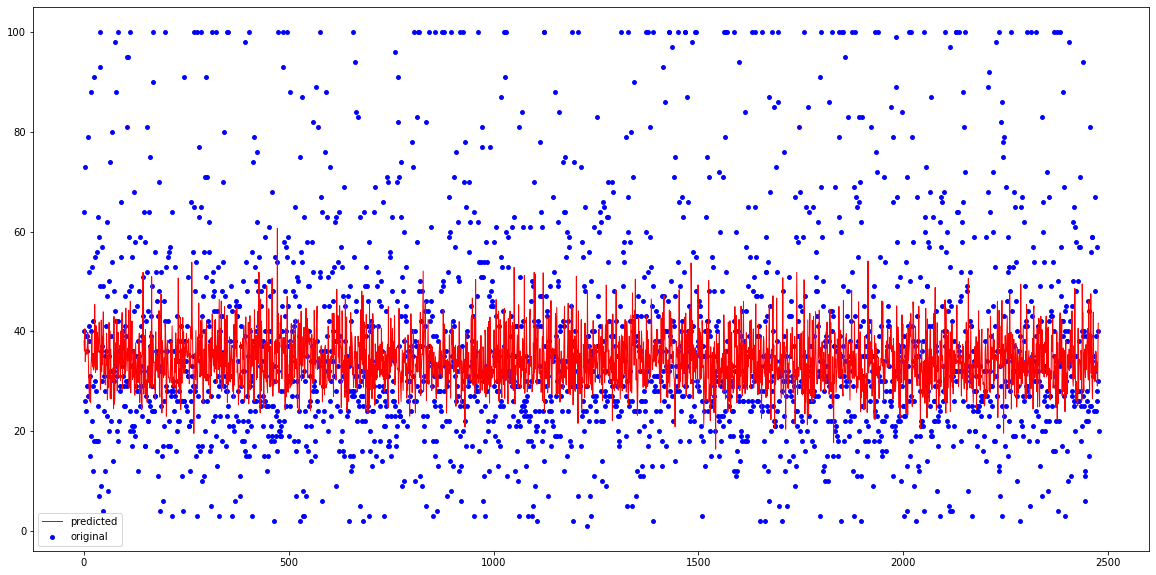

In [42]:
model_eval(CNN2, X_train, y_train, X_test, y_test, 'Second CNN')

In [43]:
CNN3 = Sequential([
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(1, activation=None),
])

model_compfit(CNN3, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 37s 160ms/step - loss: 481.4210 - root_mean_squared_error: 21.9413
Epoch 2/10
233/233 [==============================] - 38s 164ms/step - loss: 426.8123 - root_mean_squared_error: 20.6594
Epoch 3/10
233/233 [==============================] - 38s 162ms/step - loss: 422.7613 - root_mean_squared_error: 20.5612
Epoch 4/10
233/233 [==============================] - 37s 160ms/step - loss: 423.9251 - root_mean_squared_error: 20.5894
Epoch 5/10
233/233 [==============================] - 37s 161ms/step - loss: 420.3614 - root_mean_squared_error: 20.5027
Epoch 6/10
233/233 [==============================] - 37s 160ms/step - loss: 419.7194 - root_mean_squared_error: 20.4871
Epoch 7/10
233/233 [==============================] - 38s 163ms/step - loss: 421.4308 - root_mean_squared_error: 20.5288
Epoch 8/10
233/233 [==============================] - 38s 161ms/step - loss: 421.2292 - root_mean_squared_error: 20.5239
Epoch 9/10
233/233 [============

78/78 [==============================] - 3s 35ms/step - loss: 465.3493 - root_mean_squared_error: 21.5720

    Third CNN Training Metrics:
    Loss: 433.734
    Root Mean Square Error: 20.826
    Cross Validation Score: 
    ------
    Third CNN Test Metrics:
    Loss: 465.349
    Root Mean Square Error: 21.572
    


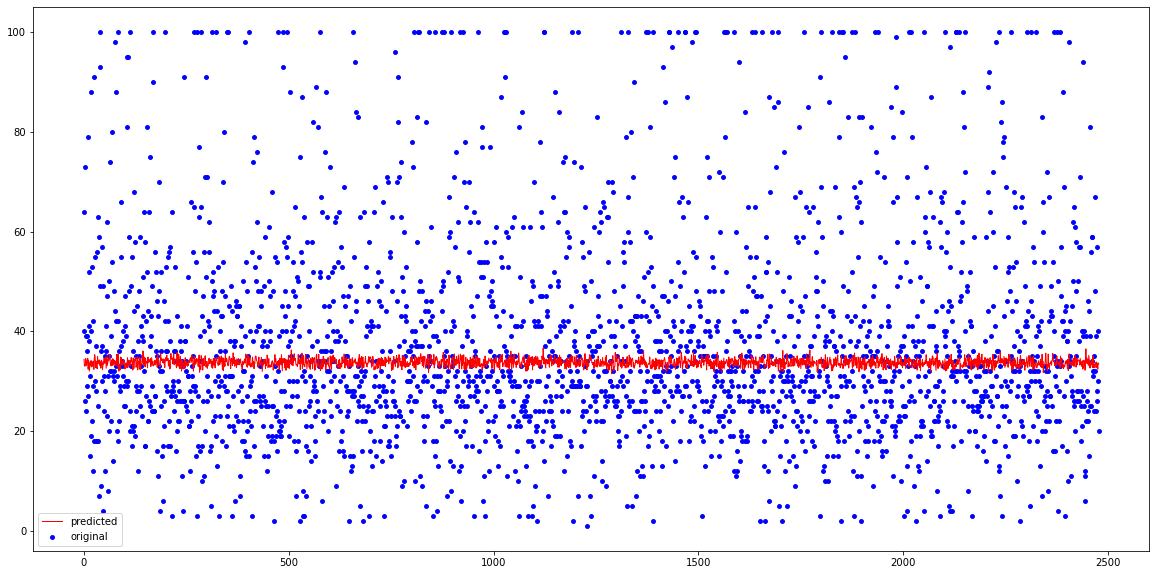

In [44]:
model_eval(CNN3, X_train, y_train, X_test, y_test, 'Third CNN')

> After running these 3 CNN models, we were not able to improve our RMSE from the baseline.

---

# <a id="Conclusion">Conclusion</a>

> We attempted Data Augmentation but found that Blurring and Flipping the images did not improve our RMSE.
>
> One big concern for us was that how `Pawpularity` was determined was unclear. There wasn't much information on the Kaggle competition description that explained how the score was created and how to interpret it. We know the scale is from 1-100, but do all the images with a score of 100 have the same amount of traffic? We think understanding how `Pawpularity` is scored would help us prepare the data for better model results.
>
> As we only had three days to complete this project, this is the best we could do.

---

# <a id="Next Steps">Next Steps</a>

> First, we would look into what goes into determining `Pawpularity`. Another thing we would like to look into would be features other than photos that affect pet profile traffic such as age of the animal and time they've been up for adoption. Lastly, our knowledge of neural networks is limited, and so, given more time, we would have liked to explore further.

## <a id="Sources">Sources</a>
- [Kaggle Competition Dataset](https://www.kaggle.com/c/petfinder-pawpularity-score)
- [Photo Metadata](https://github.com/stevenaddison/Project-4/blob/main/data/metadata.md)
- [Speed of Dog Adoption: Impact of Online Photo Traits](https://www.tandfonline.com/doi/full/10.1080/10888705.2014.982796)